In [6]:
import quake_envs
import matplotlib.pyplot as plt
import seaborn as sns
from quake_envs.simulations.building_funcs import Building, BuildingAction
import numpy as np

In [27]:
building = Building(
  id="test_building",
  damage_state_probs=np.array([0.0, 0.0, 0.0, 0.0, 1.0]),
  occtype="COM2",
  str_type="S5L",
  num_stories=2,
  sqft=1000,
  is_essential=False,
  verbose=False,
  calc_debris=True,
  stoch_ds=True,
  stoch_rt=True,
  stoch_cost=True,
  stoch_inc_loss=True,
  stoch_loss_of_function=True,
  stoch_relocation_cost=True
)

In [21]:
def repair_building(building:Building):
    repair_times = []
    incomes = []
    relocation_cost = []
    repair_cost = []
    while building.has_debris:
        repair_times.append(building.current_repair_time)
        incomes.append(building.current_income)
        relocation_cost.append(building.current_relocation_cost)
        repair_cost.append(building.current_structural_repair_cost)
        building.step(BuildingAction.CLEAR_DEBRIS)
    while building.current_repair_time > 0:
        repair_times.append(building.current_repair_time)
        incomes.append(building.current_income)
        relocation_cost.append(building.current_relocation_cost)
        repair_cost.append(building.current_structural_repair_cost)
        building.step(BuildingAction.REPAIR)
    return repair_times, incomes, relocation_cost, repair_cost


In [24]:
def plot_building(building: Building):
    repair_times, incomes, relocation_cost, repair_cost = repair_building(building)
    print(repair_times)
    print(incomes)
    print(relocation_cost)
    print(repair_cost)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(repair_times, label='Repair Time')
    # ax.plot(incomes, label='Income')
    # ax.plot(relocation_cost, label='Relocation Cost')
    # ax.plot(repair_cost, label='Repair Cost')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.legend()
    plt.show()

[]
[]
[]
[]


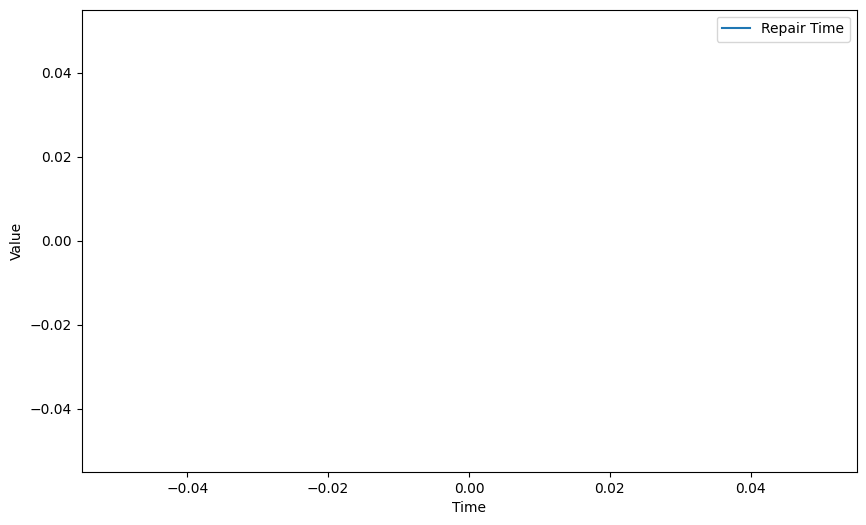

In [26]:
plot_building(building)